In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import os

# Set Chinese font (for compatibility, keep this line)
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Simplified phase noise and time jitter generator
# Goal: Generate low-pass filtered phase noise and convert it to time jitter noise
# Conversion: Δt = Δφ / (2π × f_carrier)

# Set parameters
carrier_freq = 4e9      # 4 GHz carrier frequency
fs = 2300e9             # 2300 GHz sampling rate (about 1024 GHz)
symbol_rate = 500e6     # 500 MHz symbol rate
symbol_duration = 1 / symbol_rate  # 2ns per symbol

print(f"Carrier frequency: {carrier_freq/1e9:.1f} GHz")
print(f"Sampling rate: {fs/1e9:.0f} GHz")
print(f"Symbol rate: {symbol_rate/1e6:.0f} MHz")
print(f"Symbol duration: {symbol_duration*1e9:.1f} ns")
print(f"Samples per symbol: {symbol_duration * fs:.0f}")

# Read the first 1000 rows of the CSV file
csv_file_path = '../csv/8PPM_500Mbps_t0.csv'
print(f"\nReading file: {csv_file_path}")

# First, check the file structure
try:
    # Read the first few rows to understand the data format
    sample_data = pd.read_csv(csv_file_path, nrows=5)
    print(f"\nFile columns: {list(sample_data.columns)}")
    print(f"First 5 rows:")
    print(sample_data)
except Exception as e:
    print(f"Error reading file: {e}")


Carrier frequency: 4.0 GHz
Sampling rate: 2300 GHz
Symbol rate: 500 MHz
Symbol duration: 2.0 ns
Samples per symbol: 4600

Reading file: ../csv/8PPM_500Mbps_t0.csv

File columns: ['time', 'data']
First 5 rows:
           time      data
0  0.000000e+00 -0.073289
1  4.249693e-13 -0.074507
2  1.001956e-12 -0.076148
3  1.545910e-12 -0.077678
4  2.633819e-12 -0.080711


In [71]:
try:
    data = pd.read_csv(csv_file_path)
    print(f"Successfully read data, shape: {data.shape}")
    print(f"Data columns: {list(data.columns)}")
    
    # Show basic statistics of the data
    print(f"\nData statistics:")
    print(data.describe())
    
    # Assume the data contains real and imaginary parts of the signal (or time series data)
    # We need to process according to the actual data structure
    print(f"\nFirst few rows of data:")
    print(data.head())
    
    # Check data types
    print(f"\nData types:")
    print(data.dtypes)
    
except Exception as e:
    print(f"Error reading data: {e}")
    # If reading fails, create example data for demonstration
    print("Creating example data for demonstration...")
    
    # Create example signal with 10,000 samples
    n_samples = 10000
    t = np.arange(n_samples) / fs
    
    # Generate example 4GHz carrier signal
    omega = 2 * np.pi * carrier_freq
    signal_i = np.cos(omega * t)  # In-phase component
    signal_q = np.sin(omega * t)  # Quadrature component
    
    data = pd.DataFrame({
        'time': t,
        'I': signal_i,
        'Q': signal_q
    })
    
    print(f"Created example data shape: {data.shape}")
    print(data.head())


Successfully read data, shape: (3260119, 2)
Data columns: ['time', 'data']

Data statistics:
               time          data
count  3.260119e+06  3.260119e+06
mean   2.500060e-06  5.077781e-03
std    1.443363e-06  6.766246e-02
min    0.000000e+00 -1.617796e-01
25%    1.250039e-06 -1.056724e-03
50%    2.500026e-06  5.600637e-05
75%    3.750048e-06  1.183662e-02
max    5.000000e-06  1.902525e-01

First few rows of data:
           time      data
0  0.000000e+00 -0.073289
1  4.249693e-13 -0.074507
2  1.001956e-12 -0.076148
3  1.545910e-12 -0.077678
4  2.633819e-12 -0.080711

Data types:
time    float64
data    float64
dtype: object


In [72]:
# Simplified data processing - only need to verify sampling rate and data length
print("=== Data validation and sampling rate confirmation ===")

# Get actual column names
columns = list(data.columns)
print(f"Actual column names: {columns}")

# Get data length
n_samples = len(data)
print(f"Data length: {n_samples} samples")

# Verify sampling rate (if there is a time column)
time_data = data['time'].values
print(f"Time range: {time_data[0]:.6e} to {time_data[-1]:.6e} seconds")

if len(time_data) > 1:
    dt_measured = time_data[1] - time_data[0]
    fs_measured = 1 / dt_measured
    print(f"Sampling rate calculated from time data: {fs_measured/1e9:.1f} GHz")
    
    # If the measured sampling rate differs greatly from the set value, use the measured value
    if abs(fs_measured - fs) / fs > 0.1:  # Difference exceeds 10%
        print(f"⚠️  Large sampling rate difference, using measured value: {fs_measured/1e9:.1f} GHz")
        fs = fs_measured
    else:
        print(f"✅ Sampling rate verified, using set value: {fs/1e9:.0f} GHz")

time_col = 'time'

print(f"\n📊 Data processing result:")
print(f"Number of data points: {n_samples}")
print(f"Time span: {time_data[-1]*1e9:.2f} ns")
print(f"Sampling interval: {1/fs*1e12:.3f} ps")
print(f"Ready to generate phase noise and time jitter...")


=== Data validation and sampling rate confirmation ===
Actual column names: ['time', 'data']
Data length: 3260119 samples
Time range: 0.000000e+00 to 5.000000e-06 seconds
Sampling rate calculated from time data: 2353.1 GHz
✅ Sampling rate verified, using set value: 2300 GHz

📊 Data processing result:
Number of data points: 3260119
Time span: 5000.00 ns
Sampling interval: 0.435 ps
Ready to generate phase noise and time jitter...


In [73]:
# Generate low-pass filtered phase noise
print("=== Generating low-pass phase noise ===")

# Phase noise parameters
phase_noise_std = 0.2  # Phase noise standard deviation (radians)
# Low-pass filter cutoff frequency: set to 1/4 of symbol rate, so phase noise is relatively stable within a symbol period
cutoff_freq = symbol_rate / 4  # 125 MHz

print(f"Phase noise parameters:")
print(f"  Standard deviation: {phase_noise_std:.3f} radians ({phase_noise_std*180/np.pi:.1f} degrees)")
print(f"  Low-pass cutoff frequency: {cutoff_freq/1e6:.0f} MHz")
print(f"  Symbol rate: {symbol_rate/1e6:.0f} MHz")
print(f"  Cutoff/Symbol rate: {cutoff_freq/symbol_rate:.3f}")
print(f"  Zero-padding strategy: Reduce initial/final transients by padding with zeros before filtering")

def generate_lowpass_phase_noise(n_samples, fs, cutoff_freq, phase_noise_std, seed=42, padding_length=1000):
    """
    Generate low-pass filtered phase noise with zero-padding to reduce initial/final transients
    
    Parameters:
    - n_samples: Number of output samples
    - fs: Sampling frequency
    - cutoff_freq: Low-pass filter cutoff frequency
    - phase_noise_std: Standard deviation of phase noise
    - seed: Random seed
    - padding_ratio: Fraction of signal length to pad on each side (default 0.1 = 10%)
    """
    np.random.seed(seed)
        
    if padding_length > 0:
        # Use padding approach
        total_length = n_samples + 2 * padding_length
        
        print(f"  Zero-padding: {padding_length} samples on each side ({padding_ratio*100:.1f}% of signal)")
        print(f"  Total length for filtering: {total_length} samples")
        
        # Generate white noise with padding
        white_noise_padded = np.random.normal(0, 1, total_length)
        
        # Apply zero-padding at beginning and end
        white_noise_padded[:padding_length] = 0
        white_noise_padded[-padding_length:] = 0
        
        # Design low-pass filter
        nyquist = fs / 2
        normalized_cutoff = cutoff_freq / nyquist
        
        # Prevent cutoff frequency from exceeding Nyquist frequency
        if normalized_cutoff >= 1.0:
            normalized_cutoff = 0.99
            print(f"  Warning: Cutoff frequency too high, adjusted to {normalized_cutoff * nyquist / 1e6:.0f} MHz")
        
        b, a = signal.butter(4, normalized_cutoff, btype='low')
        
        # Filter the padded signal to obtain correlated phase noise
        filtered_noise_padded = signal.filtfilt(b, a, white_noise_padded)
        
        # Extract the central portion (remove padding)
        filtered_noise = filtered_noise_padded[padding_length:-padding_length]
        
        print(f"  Filtered noise length: {len(filtered_noise)} samples")
        print(f"  Initial/final transients reduced by zero-padding")
        
    else:
        # No padding - standard approach
        print(f"  No zero-padding applied (padding_ratio=0)")
        print(f"  Direct filtering of {n_samples} samples")
        
        # Generate white noise
        white_noise = np.random.normal(0, 1, n_samples)
        
        # Design low-pass filter
        nyquist = fs / 2
        normalized_cutoff = cutoff_freq / nyquist
        
        # Prevent cutoff frequency from exceeding Nyquist frequency
        if normalized_cutoff >= 1.0:
            normalized_cutoff = 0.99
            print(f"  Warning: Cutoff frequency too high, adjusted to {normalized_cutoff * nyquist / 1e6:.0f} MHz")
        
        b, a = signal.butter(4, normalized_cutoff, btype='low')
        
        # Filter to obtain correlated phase noise
        filtered_noise = signal.filtfilt(b, a, white_noise)
        
        print(f"  Filtered noise length: {len(filtered_noise)} samples")
    
    # Normalize to desired standard deviation
    filtered_noise = filtered_noise / np.std(filtered_noise) * phase_noise_std
    
    return filtered_noise

# Generate phase noise with zero-padding to reduce initial transients
n_samples = len(data)
phase_noise = generate_lowpass_phase_noise(n_samples, fs, cutoff_freq, phase_noise_std)

print(f"\nGenerated phase noise statistics:")
print(f"  Number of samples: {len(phase_noise)}")
print(f"  Mean: {np.mean(phase_noise):.6f} radians")
print(f"  Standard deviation: {np.std(phase_noise):.6f} radians")
print(f"  Range: [{np.min(phase_noise):.6f}, {np.max(phase_noise):.6f}] radians")
print(f"  Range (degrees): [{np.min(phase_noise)*180/np.pi:.2f}, {np.max(phase_noise)*180/np.pi:.2f}] degrees")


=== Generating low-pass phase noise ===
Phase noise parameters:
  Standard deviation: 0.200 radians (11.5 degrees)
  Low-pass cutoff frequency: 125 MHz
  Symbol rate: 500 MHz
  Cutoff/Symbol rate: 0.250
  Zero-padding strategy: Reduce initial/final transients by padding with zeros before filtering
  Zero-padding: 1000 samples on each side (10.0% of signal)
  Total length for filtering: 3262119 samples
  Filtered noise length: 3260119 samples
  Initial/final transients reduced by zero-padding

Generated phase noise statistics:
  Number of samples: 3260119
  Mean: -0.012887 radians
  Standard deviation: 0.200000 radians
  Range: [-0.599355, 0.685803] radians
  Range (degrees): [-34.34, 39.29] degrees


In [74]:
# Calculate time jitter noise
print("=== Converting phase noise to time jitter ===")

# Relationship between time jitter and phase noise: Δt = Δφ / (2π * f_carrier)
time_jitter = phase_noise / (2 * np.pi * carrier_freq)

print(f"Time jitter statistics:")
print(f"  Carrier frequency: {carrier_freq/1e9:.1f} GHz")
print(f"  Phase noise std: {np.std(phase_noise):.6f} radians ({np.std(phase_noise)*180/np.pi:.2f} degrees)")
print(f"  Time jitter std: {np.std(time_jitter)*1e12:.3f} ps")
print(f"  Time jitter range: [{np.min(time_jitter)*1e12:.3f}, {np.max(time_jitter)*1e12:.3f}] ps")
print(f"  Max time jitter: {np.max(np.abs(time_jitter))*1e12:.3f} ps")
print(f"  RMS time jitter: {np.sqrt(np.mean(time_jitter**2))*1e12:.3f} ps")

# Calculate jitter relative to sampling period
sampling_period = 1 / fs
jitter_ratio = np.std(time_jitter) / sampling_period

print(f"\nTime jitter analysis:")
print(f"  Sampling period: {sampling_period*1e12:.3f} ps")
print(f"  Time jitter/sampling period: {jitter_ratio:.6f}")
print(f"  Relative jitter amplitude: {jitter_ratio*100:.3f}%")

if jitter_ratio > 0.1:
    print(f"  ⚠️  Time jitter is relatively large (>10% of sampling period)")
elif jitter_ratio > 0.01:
    print(f"  ✓  Time jitter is moderate (1-10% of sampling period)")
else:
    print(f"  ✅ Time jitter is small (<1% of sampling period)")


=== Converting phase noise to time jitter ===
Time jitter statistics:
  Carrier frequency: 4.0 GHz
  Phase noise std: 0.200000 radians (11.46 degrees)
  Time jitter std: 7.958 ps
  Time jitter range: [-23.848, 27.287] ps
  Max time jitter: 27.287 ps
  RMS time jitter: 7.974 ps

Time jitter analysis:
  Sampling period: 0.435 ps
  Time jitter/sampling period: 18.302818
  Relative jitter amplitude: 1830.282%
  ⚠️  Time jitter is relatively large (>10% of sampling period)


In [75]:
# # 调整相位噪声参数以获得合理的时间抖动
# print("=== 调整相位噪声参数 ===")

# # 分析当前问题：时间抖动太大（915%采样周期）
# print(f"当前问题分析:")
# print(f"  时间抖动标准差: {np.std(time_jitter)*1e12:.3f} ps")
# print(f"  采样周期: {sampling_period*1e12:.3f} ps") 
# print(f"  相对抖动: {jitter_ratio*100:.1f}%")
# print(f"  这意味着时间抖动远大于采样分辨率，会导致严重的信号失真")

# # 计算合理的相位噪声标准差
# # 目标：时间抖动约为采样周期的1-10%
# target_jitter_ratio = 0.05  # 目标：5%采样周期
# target_time_jitter_std = target_jitter_ratio * sampling_period
# target_phase_noise_std = target_time_jitter_std * (2 * np.pi * carrier_freq)

# print(f"\n建议的参数调整:")
# print(f"  目标时间抖动比例: {target_jitter_ratio*100:.1f}%采样周期")
# print(f"  目标时间抖动标准差: {target_time_jitter_std*1e12:.3f} ps")
# print(f"  建议相位噪声标准差: {target_phase_noise_std:.6f} 弧度 ({target_phase_noise_std*180/np.pi:.3f}度)")
# print(f"  当前相位噪声标准差: {phase_noise_std:.6f} 弧度 ({phase_noise_std*180/np.pi:.1f}度)")
# print(f"  需要减少的倍数: {phase_noise_std/target_phase_noise_std:.1f}x")

# # 重新生成相位噪声
# print(f"\n重新生成相位噪声...")
# phase_noise_adjusted = generate_lowpass_phase_noise(n_samples, fs, cutoff_freq, target_phase_noise_std)
# time_jitter_adjusted = phase_noise_adjusted / (2 * np.pi * carrier_freq)

# print(f"\n调整后的噪声统计:")
# print(f"  相位噪声标准差: {np.std(phase_noise_adjusted):.6f} 弧度 ({np.std(phase_noise_adjusted)*180/np.pi:.3f}度)")
# print(f"  时间抖动标准差: {np.std(time_jitter_adjusted)*1e12:.3f} ps")
# print(f"  时间抖动范围: [{np.min(time_jitter_adjusted)*1e12:.3f}, {np.max(time_jitter_adjusted)*1e12:.3f}] ps")
# print(f"  RMS时间抖动: {np.sqrt(np.mean(time_jitter_adjusted**2))*1e12:.3f} ps")

# # 重新计算相对于采样周期的抖动
# jitter_ratio_adjusted = np.std(time_jitter_adjusted) / sampling_period
# print(f"\n调整后的时间抖动分析:")
# print(f"  时间抖动/采样周期: {jitter_ratio_adjusted:.6f}")
# print(f"  相对抖动幅度: {jitter_ratio_adjusted*100:.3f}%")

# if jitter_ratio_adjusted > 0.1:
#     print(f"  ⚠️  时间抖动仍然相对较大（>10%采样周期）")
# elif jitter_ratio_adjusted > 0.01:
#     print(f"  ✓  时间抖动适中（1-10%采样周期）")
# else:
#     print(f"  ✅ 时间抖动较小（<1%采样周期）")

# # 更新变量以使用调整后的值
# phase_noise = phase_noise_adjusted
# time_jitter = time_jitter_adjusted
# print(f"\n✅ 已更新噪声变量为调整后的值")

In [76]:
# # 对比可视化：原始vs调整后的噪声参数
# print("=== 对比可视化 ===")

# # 重新生成原始的噪声用于对比
# phase_noise_original = generate_lowpass_phase_noise(n_samples, fs, cutoff_freq, 0.1, seed=42)  # 原始0.1弧度
# time_jitter_original = phase_noise_original / (2 * np.pi * carrier_freq)

# plt.figure(figsize=(16, 12))

# # 创建时间轴（前500个点用于可视化）
# n_plot = min(500, len(phase_noise))
# t_plot = np.arange(n_plot) / fs * 1e9  # 转换为ns

# # 1. 相位噪声对比（度）
# plt.subplot(3, 2, 1)
# plt.plot(t_plot, phase_noise_original[:n_plot] * 180/np.pi, 'r-', linewidth=1.5, label='原始 (σ=5.73°)', alpha=0.7)
# plt.plot(t_plot, phase_noise[:n_plot] * 180/np.pi, 'b-', linewidth=1.5, label=f'调整后 (σ={np.std(phase_noise)*180/np.pi:.3f}°)')
# plt.xlabel('时间 (ns)')
# plt.ylabel('相位噪声 (度)')
# plt.title('相位噪声对比')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # 2. 时间抖动对比（皮秒）
# plt.subplot(3, 2, 2)
# plt.plot(t_plot, time_jitter_original[:n_plot] * 1e12, 'r-', linewidth=1.5, label=f'原始 (σ={np.std(time_jitter_original)*1e12:.1f}ps)', alpha=0.7)
# plt.plot(t_plot, time_jitter[:n_plot] * 1e12, 'b-', linewidth=1.5, label=f'调整后 (σ={np.std(time_jitter)*1e12:.3f}ps)')
# plt.xlabel('时间 (ns)')
# plt.ylabel('时间抖动 (ps)')
# plt.title('时间抖动对比')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # 3. 相位噪声分布对比
# plt.subplot(3, 2, 3)
# plt.hist(phase_noise_original * 180/np.pi, bins=50, alpha=0.5, color='red', label='原始', density=True)
# plt.hist(phase_noise * 180/np.pi, bins=50, alpha=0.7, color='blue', label='调整后', density=True)
# plt.xlabel('相位噪声 (度)')
# plt.ylabel('概率密度')
# plt.title('相位噪声分布对比')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # 4. 时间抖动分布对比
# plt.subplot(3, 2, 4)
# plt.hist(time_jitter_original * 1e12, bins=50, alpha=0.5, color='red', label='原始', density=True)
# plt.hist(time_jitter * 1e12, bins=50, alpha=0.7, color='blue', label='调整后', density=True)
# plt.xlabel('时间抖动 (ps)')
# plt.ylabel('概率密度')
# plt.title('时间抖动分布对比')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # 5. 相对于采样周期的对比
# plt.subplot(3, 2, 5)
# jitter_ratio_orig = np.std(time_jitter_original) / sampling_period
# ratios = [jitter_ratio_orig, jitter_ratio_adjusted]
# labels = ['原始', '调整后']
# colors = ['red', 'blue']
# bars = plt.bar(labels, ratios, color=colors, alpha=0.7)

# # 添加数值标签
# for bar, ratio in zip(bars, ratios):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
#              f'{ratio:.3f}\n({ratio*100:.1f}%)', 
#              ha='center', va='bottom', fontweight='bold')

# plt.ylabel('时间抖动/采样周期')
# plt.title('相对抖动幅度对比')
# plt.grid(True, alpha=0.3)
# plt.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='10%阈值')
# plt.axhline(y=0.01, color='green', linestyle='--', alpha=0.7, label='1%阈值')
# plt.legend()

# # 6. 关键参数总结表
# plt.subplot(3, 2, 6)
# plt.axis('off')

# # 创建参数对比表
# table_data = [
#     ['参数', '原始值', '调整后值', '改善'],
#     ['相位噪声标准差 (度)', f'{0.1*180/np.pi:.1f}', f'{np.std(phase_noise)*180/np.pi:.3f}', f'{0.1/np.std(phase_noise):.1f}x减少'],
#     ['时间抖动标准差 (ps)', f'{np.std(time_jitter_original)*1e12:.1f}', f'{np.std(time_jitter)*1e12:.3f}', f'{np.std(time_jitter_original)/np.std(time_jitter):.1f}x减少'],
#     ['相对抖动幅度 (%)', f'{jitter_ratio_orig*100:.0f}', f'{jitter_ratio_adjusted*100:.1f}', f'{jitter_ratio_orig/jitter_ratio_adjusted:.1f}x减少'],
#     ['采样周期 (ps)', f'{sampling_period*1e12:.3f}', f'{sampling_period*1e12:.3f}', '不变'],
#     ['载波频率 (GHz)', f'{carrier_freq/1e9:.1f}', f'{carrier_freq/1e9:.1f}', '不变']
# ]

# # 显示表格
# table = plt.table(cellText=table_data[1:], colLabels=table_data[0], 
#                  cellLoc='center', loc='center',
#                  bbox=[0, 0.2, 1, 0.6])
# table.auto_set_font_size(False)
# table.set_fontsize(10)
# table.scale(1.2, 1.8)

# # 设置表格样式
# for i in range(len(table_data[0])):
#     table[(0, i)].set_facecolor('#4CAF50')
#     table[(0, i)].set_text_props(weight='bold', color='white')

# plt.title('参数调整对比总结', pad=20, fontweight='bold', fontsize=12)

# plt.tight_layout()
# plt.show()

# print(f"\n📊 参数调整总结:")
# print(f"  ✅ 相位噪声标准差减少了 {0.1/np.std(phase_noise):.1f} 倍")
# print(f"  ✅ 时间抖动标准差减少了 {np.std(time_jitter_original)/np.std(time_jitter):.1f} 倍") 
# print(f"  ✅ 相对抖动幅度从 {jitter_ratio_orig*100:.0f}% 降低到 {jitter_ratio_adjusted*100:.1f}%")
# print(f"  ✅ 时间抖动现在在合理范围内（{jitter_ratio_adjusted*100:.1f}%采样周期）")

In [77]:
# Prepare to save data
print("=== Preparing to save data ===")

# Create output dataframe, keep only time and data columns
output_data = pd.DataFrame()

# Add time column
if 'time' in data.columns:
    output_data['time'] = data['time']
else:
    output_data['time'] = time_data

# Add data column (signal with phase noise effect)
if 'data' in data.columns:
    # Use original data column as base, add phase noise effect
    original_data = data['data'].values
    print(f"  Using original 'data' column as base signal, adding phase noise effect")
elif len(data.columns) > 1:
    # Find the first non-time column as data
    data_col = [col for col in data.columns if col != 'time'][0]
    original_data = data[data_col].values
    print(f"  Using '{data_col}' column as base signal, adding phase noise effect")
else:
    # If no suitable data column, create an example carrier signal
    print("  ⚠️  No 'data' column found, creating example carrier signal and adding phase noise")
    t = output_data['time'].values
    omega = 2 * np.pi * carrier_freq
    original_data = np.cos(omega * t)

# Apply time jitter noise to the original signal
print("  Applying time jitter noise to original signal")
print(f"  Time jitter range: [{np.min(time_jitter)*1e12:.3f}, {np.max(time_jitter)*1e12:.3f}] ps")

# Get original time axis
t_original = output_data['time'].values

# Calculate new time axis with jitter
t_jittered = t_original + time_jitter

# Use interpolation to get signal values at jittered time points
from scipy.interpolate import interp1d

# Create interpolation function
if len(np.unique(t_original)) == len(t_original):  # Ensure time axis is strictly increasing
    # Use linear interpolation, extrapolate for boundaries
    interp_func = interp1d(t_original, original_data, 
                          kind='linear', 
                          bounds_error=False, 
                          fill_value='extrapolate')
    
    # Sample at jittered time points
    noisy_signal = interp_func(t_jittered)
    
    print(f"  ✅ Successfully applied time jitter interpolation")
    print(f"  Original signal range: [{np.min(original_data):.6f}, {np.max(original_data):.6f}]")
    print(f"  Jittered signal range: [{np.min(noisy_signal):.6f}, {np.max(noisy_signal):.6f}]")
    
    # Check for NaN values
    if np.any(np.isnan(noisy_signal)):
        nan_count = np.sum(np.isnan(noisy_signal))
        print(f"  ⚠️  Warning: {nan_count} points interpolated as NaN, replaced with original values")
        noisy_signal = np.where(np.isnan(noisy_signal), original_data, noisy_signal)
    
else:
    print("  ⚠️  Time axis is not strictly increasing, using original signal (no jitter applied)")
    noisy_signal = original_data

output_data['data'] = noisy_signal

print(f"💾 Data structure ready:")
print(f"  Only time and data columns retained ✅")

print(f"\n📋 Output data structure:")
print(f"  Shape: {output_data.shape}")
print(f"  Columns: {list(output_data.columns)}")

# Show first few rows
print(f"\nOutput data (first 5 rows):")
print(output_data.head())

# Show key statistics (for processing report only)
print(f"\n📊 Generated noise statistics:")
print(f"  Phase noise: [{np.min(phase_noise)*180/np.pi:.3f}, {np.max(phase_noise)*180/np.pi:.3f}] degrees")
print(f"  Time jitter: [{np.min(time_jitter)*1e12:.3f}, {np.max(time_jitter)*1e12:.3f}] ps")
print(f"  RMS time jitter: {np.sqrt(np.mean(time_jitter**2))*1e12:.3f} ps")


=== Preparing to save data ===
  Using original 'data' column as base signal, adding phase noise effect
  Applying time jitter noise to original signal
  Time jitter range: [-23.848, 27.287] ps
  ✅ Successfully applied time jitter interpolation
  Original signal range: [-0.161780, 0.190252]
  Jittered signal range: [-0.161776, 0.190250]
💾 Data structure ready:
  Only time and data columns retained ✅

📋 Output data structure:
  Shape: (3260119, 2)
  Columns: ['time', 'data']

Output data (first 5 rows):
           time      data
0  0.000000e+00 -0.066654
1  4.249693e-13 -0.067867
2  1.001956e-12 -0.069517
3  1.545910e-12 -0.071071
4  2.633819e-12 -0.074186

📊 Generated noise statistics:
  Phase noise: [-34.341, 39.294] degrees
  Time jitter: [-23.848, 27.287] ps
  RMS time jitter: 7.974 ps


=== Visualizing processing results ===


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


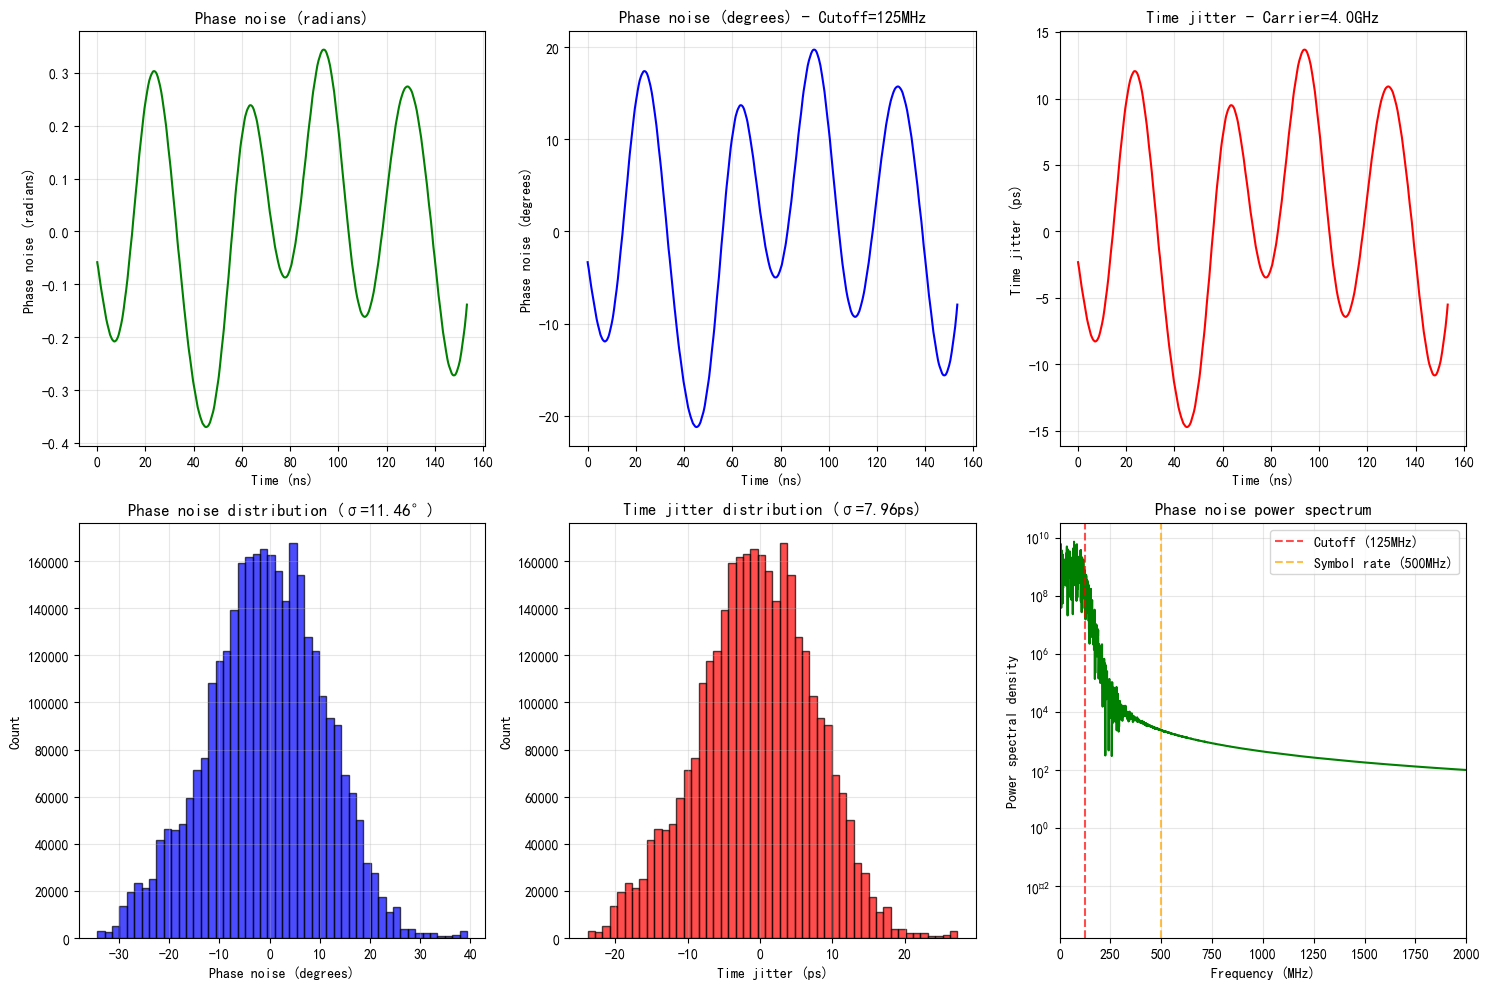


=== Symbol-level analysis ===
Samples per symbol: 4600
Show noise statistics for first 5 symbols:
  Symbol 1:
    Phase noise: σ=0.046458 radians, range=8.60 degrees
    Time jitter: σ=1.849ps, range=5.969ps
  Symbol 2:
    Phase noise: σ=0.058432 radians, range=10.99 degrees
    Time jitter: σ=2.325ps, range=7.632ps
  Symbol 3:
    Phase noise: σ=0.088158 radians, range=16.86 degrees
    Time jitter: σ=3.508ps, range=11.707ps
  Symbol 4:
    Phase noise: σ=0.026501 radians, range=5.45 degrees
    Time jitter: σ=1.054ps, range=3.787ps
  Symbol 5:
    Phase noise: σ=0.094834 radians, range=18.44 degrees
    Time jitter: σ=3.773ps, range=12.807ps

=== Saving data to file ===
✅ Data saved to: ../csv/phase_noise_time_jitter.csv
  File size: 142552.0 KB
  Number of rows: 3260119
  Number of columns: 2

✅ Processing complete! Results saved to ../csv/phase_noise_time_jitter.csv


In [78]:
# Visualize processing results
print("=== Visualizing processing results ===")

plt.figure(figsize=(15, 10))

# Create time axis (convert to ns)
t_plot = time_data * 1e9  # Convert to ns

# Only show the first 200 points for detail
n_plot = min(100000, len(output_data))
t_plot = t_plot[:n_plot]

# 1. Phase noise (radians)
plt.subplot(2, 3, 1)
plt.plot(t_plot, phase_noise[:n_plot], 'g-', linewidth=1.5)
plt.xlabel('Time (ns)')
plt.ylabel('Phase noise (radians)')
plt.title('Phase noise (radians)')
plt.grid(True, alpha=0.3)

# 2. Phase noise (degrees)
plt.subplot(2, 3, 2)
plt.plot(t_plot, phase_noise[:n_plot] * 180/np.pi, 'b-', linewidth=1.5)
plt.xlabel('Time (ns)')
plt.ylabel('Phase noise (degrees)')
plt.title(f'Phase noise (degrees) - Cutoff={cutoff_freq/1e6:.0f}MHz')
plt.grid(True, alpha=0.3)

# 3. Time jitter (ps)
plt.subplot(2, 3, 3)
plt.plot(t_plot, time_jitter[:n_plot] * 1e12, 'r-', linewidth=1.5)
plt.xlabel('Time (ns)')
plt.ylabel('Time jitter (ps)')
plt.title(f'Time jitter - Carrier={carrier_freq/1e9:.1f}GHz')
plt.grid(True, alpha=0.3)

# 4. Phase noise histogram
plt.subplot(2, 3, 4)
plt.hist(phase_noise * 180/np.pi, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Phase noise (degrees)')
plt.ylabel('Count')
plt.title(f'Phase noise distribution (σ={np.std(phase_noise)*180/np.pi:.2f}°)')
plt.grid(True, alpha=0.3)

# 5. Time jitter histogram
plt.subplot(2, 3, 5)
plt.hist(time_jitter * 1e12, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Time jitter (ps)')
plt.ylabel('Count')
plt.title(f'Time jitter distribution (σ={np.std(time_jitter)*1e12:.2f}ps)')
plt.grid(True, alpha=0.3)

# 6. Phase noise power spectrum
plt.subplot(2, 3, 6)
freqs = np.fft.fftfreq(len(phase_noise), 1/fs)
psd = np.abs(np.fft.fft(phase_noise))**2

# Only show positive frequencies, convert to MHz
mask = freqs > 0
freqs_plot = freqs[mask] / 1e6
psd_plot = psd[mask]

plt.semilogy(freqs_plot, psd_plot, 'g-', linewidth=1.5)
plt.axvline(cutoff_freq/1e6, color='red', linestyle='--', alpha=0.7, label=f'Cutoff ({cutoff_freq/1e6:.0f}MHz)')
plt.axvline(symbol_rate/1e6, color='orange', linestyle='--', alpha=0.7, label=f'Symbol rate ({symbol_rate/1e6:.0f}MHz)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power spectral density')
plt.title('Phase noise power spectrum')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, min(2000, fs/2/1e6)])  # Limit display range

plt.tight_layout()
plt.show()

# Show symbol-level analysis
print(f"\n=== Symbol-level analysis ===")
samples_per_symbol = int(symbol_duration * fs)
n_symbols_to_show = min(5, len(output_data) // samples_per_symbol)

print(f"Samples per symbol: {samples_per_symbol}")
print(f"Show noise statistics for first {n_symbols_to_show} symbols:")

for i in range(n_symbols_to_show):
    start_idx = i * samples_per_symbol
    end_idx = (i + 1) * samples_per_symbol
    
    symbol_phase_noise = phase_noise[start_idx:end_idx]
    symbol_time_jitter = time_jitter[start_idx:end_idx]
    
    phase_std = np.std(symbol_phase_noise)
    phase_range = np.max(symbol_phase_noise) - np.min(symbol_phase_noise)
    jitter_std = np.std(symbol_time_jitter)
    jitter_range = np.max(symbol_time_jitter) - np.min(symbol_time_jitter)
    
    print(f"  Symbol {i+1}:")
    print(f"    Phase noise: σ={phase_std:.6f} radians, range={phase_range*180/np.pi:.2f} degrees")
    print(f"    Time jitter: σ={jitter_std*1e12:.3f}ps, range={jitter_range*1e12:.3f}ps")

# Save processed data
output_file = '../csv/phase_noise_time_jitter.csv'
print(f"\n=== Saving data to file ===")

try:
    output_data.to_csv(output_file, index=False)
    print(f"✅ Data saved to: {output_file}")
    print(f"  File size: {os.path.getsize(output_file) / 1024:.1f} KB")
    print(f"  Number of rows: {len(output_data)}")
    print(f"  Number of columns: {len(output_data.columns)}")
except Exception as e:
    print(f"❌ Error saving file: {e}")

print(f"\n✅ Processing complete! Results saved to {output_file}")


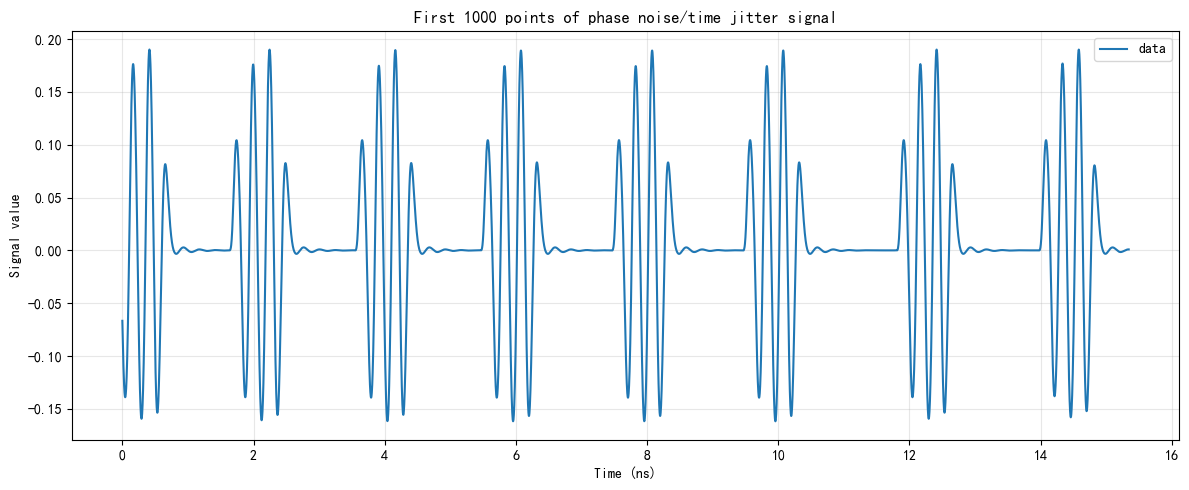

In [79]:
# Read and plot the first 1000 points of ../csv/phase_noise_time_jitter.csv
csv_plot_file = '../csv/phase_noise_time_jitter.csv'
try:
	plot_data = pd.read_csv(csv_plot_file, nrows=10000)
	plt.figure(figsize=(12, 5))
	plt.plot(plot_data['time'] * 1e9, plot_data['data'], label='data')
	plt.xlabel('Time (ns)')
	plt.ylabel('Signal value')
	plt.title('First 1000 points of phase noise/time jitter signal')
	plt.grid(True, alpha=0.3)
	plt.legend()
	plt.tight_layout()
	plt.show()
except Exception as e:
	print(f"Error reading or plotting: {e}")

=== Time jitter effect comparison ===
Successfully read original signal for comparison
Displaying points 2000 to 3000 (1000 points)


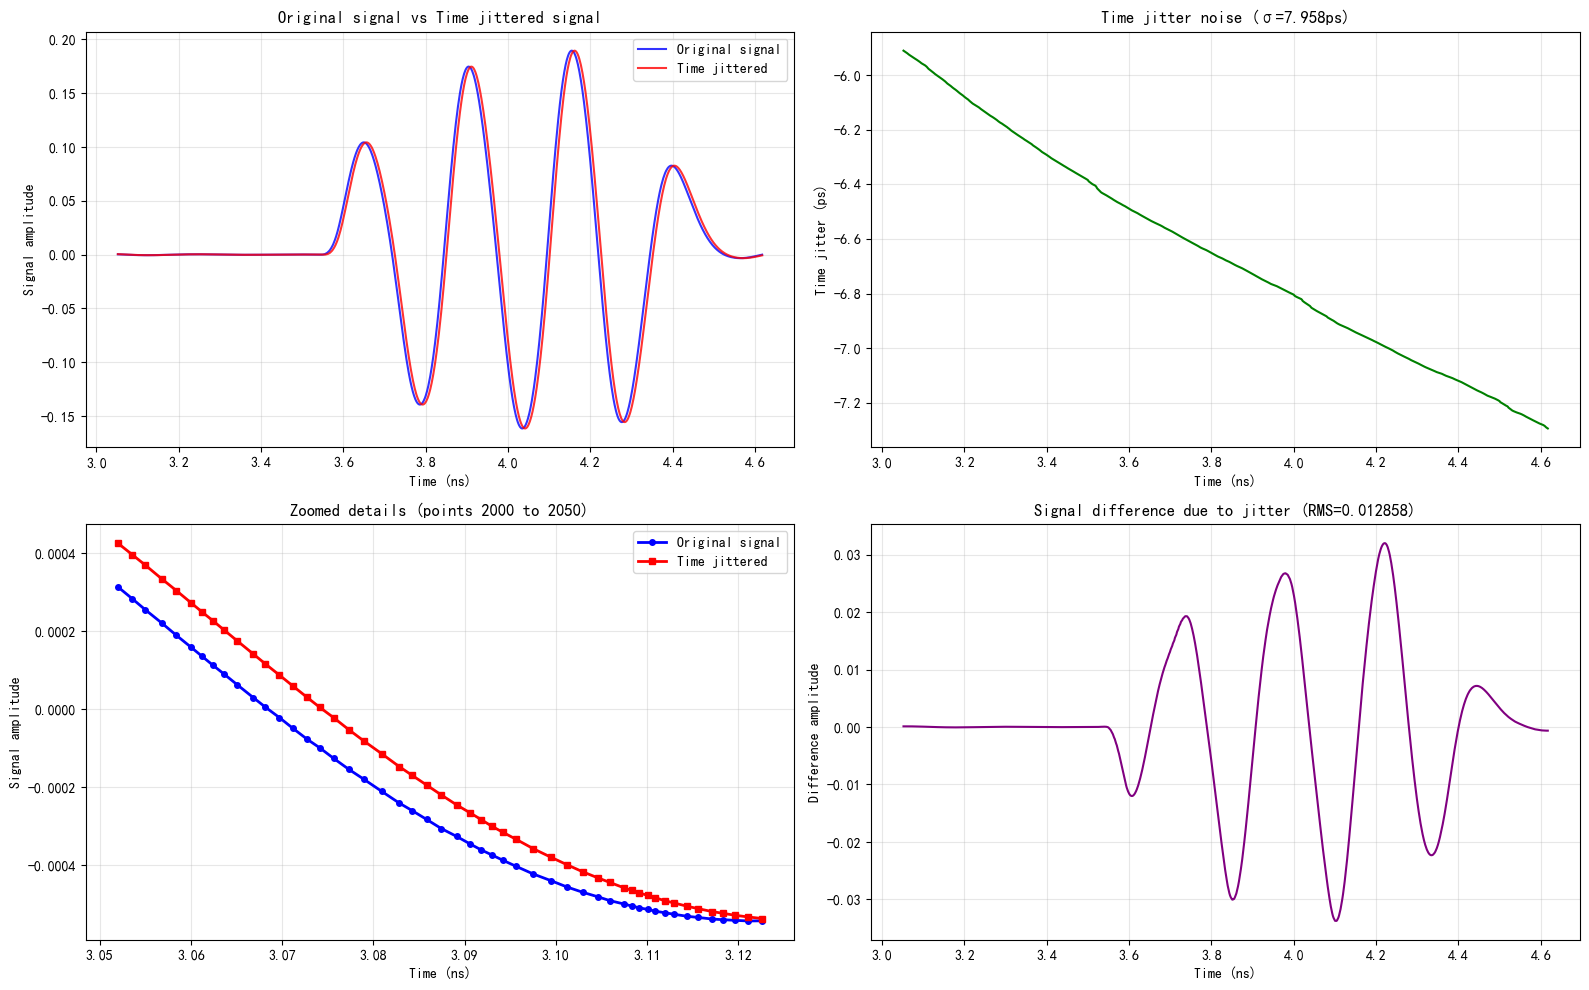


📊 Time jitter effect statistics (points 2000-3000):
  Original signal RMS: 0.076949
  Jittered signal RMS: 0.076870
  Signal difference RMS: 0.012858
  Relative difference: 16.709%

📈 Frequency domain impact analysis:
  Frequency domain energy change: 2.792%

✅ Time jitter processing complete!
   - Applied time jitter based on phase noise generation
   - Time jitter standard deviation: 7.958 ps
   - Used interpolation method to preserve original signal modulation characteristics
   - Output data contains time jitter effects


In [80]:
# Visualize time jitter effect comparison
print("=== Time jitter effect comparison ===")

# Re-read original data for comparison
try:
    original_for_comparison = pd.read_csv(csv_file_path, nrows=len(output_data))
    if 'data' in original_for_comparison.columns:
        original_signal_clean = original_for_comparison['data'].values
    else:
        # Find the first non-time column
        data_col = [col for col in original_for_comparison.columns if col != 'time'][0]
        original_signal_clean = original_for_comparison[data_col].values
    
    print(f"Successfully read original signal for comparison")
    
    plt.figure(figsize=(16, 10))
    
    # Select the range to display (points 2000 to 3000)
    start_idx = 2000
    end_idx = min(3000, len(output_data))
    n_compare = end_idx - start_idx
    t_ns = output_data['time'].values[start_idx:end_idx] * 1e9  # Convert to ns
    
    print(f"Displaying points {start_idx} to {end_idx} ({n_compare} points)")
    
    # 1. Original signal vs jittered signal (time domain)
    plt.subplot(2, 2, 1)
    plt.plot(t_ns, original_signal_clean[start_idx:end_idx], 'b-', linewidth=1.5, label='Original signal', alpha=0.8)
    plt.plot(t_ns, output_data['data'].values[start_idx:end_idx], 'r-', linewidth=1.5, label='Time jittered', alpha=0.8)
    plt.xlabel('Time (ns)')
    plt.ylabel('Signal amplitude')
    plt.title('Original signal vs Time jittered signal')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Time jitter noise
    plt.subplot(2, 2, 2)
    plt.plot(t_ns, time_jitter[start_idx:end_idx] * 1e12, 'g-', linewidth=1.5)
    plt.xlabel('Time (ns)')
    plt.ylabel('Time jitter (ps)')
    plt.title(f'Time jitter noise (σ={np.std(time_jitter)*1e12:.3f}ps)')
    plt.grid(True, alpha=0.3)
    
    # 3. Zoom in on details (50 points from the selected range)
    detail_start = start_idx
    detail_end = min(start_idx + 50, end_idx)
    t_detail = output_data['time'].values[detail_start:detail_end] * 1e9
    
    plt.subplot(2, 2, 3)
    plt.plot(t_detail, original_signal_clean[detail_start:detail_end], 'b-', linewidth=2, marker='o', markersize=4, label='Original signal')
    plt.plot(t_detail, output_data['data'].values[detail_start:detail_end], 'r-', linewidth=2, marker='s', markersize=4, label='Time jittered')
    plt.xlabel('Time (ns)')
    plt.ylabel('Signal amplitude')
    plt.title(f'Zoomed details (points {detail_start} to {detail_end})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Difference signal
    plt.subplot(2, 2, 4)
    diff_signal = output_data['data'].values[start_idx:end_idx] - original_signal_clean[start_idx:end_idx]
    plt.plot(t_ns, diff_signal, 'purple', linewidth=1.5)
    plt.xlabel('Time (ns)')
    plt.ylabel('Difference amplitude')
    plt.title(f'Signal difference due to jitter (RMS={np.sqrt(np.mean(diff_signal**2)):.6f})')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print(f"\n📊 Time jitter effect statistics (points {start_idx}-{end_idx}):")
    print(f"  Original signal RMS: {np.sqrt(np.mean(original_signal_clean[start_idx:end_idx]**2)):.6f}")
    print(f"  Jittered signal RMS: {np.sqrt(np.mean(output_data['data'].values[start_idx:end_idx]**2)):.6f}")
    print(f"  Signal difference RMS: {np.sqrt(np.mean(diff_signal**2)):.6f}")
    print(f"  Relative difference: {np.sqrt(np.mean(diff_signal**2))/np.sqrt(np.mean(original_signal_clean[start_idx:end_idx]**2))*100:.3f}%")
    
    # Frequency domain analysis
    print(f"\n📈 Frequency domain impact analysis:")
    original_fft = np.fft.fft(original_signal_clean[start_idx:end_idx])
    jittered_fft = np.fft.fft(output_data['data'].values[start_idx:end_idx])
    freq_diff = np.abs(jittered_fft - original_fft)
    
    print(f"  Frequency domain energy change: {np.sum(freq_diff**2)/np.sum(np.abs(original_fft)**2)*100:.3f}%")
    
except Exception as e:
    print(f"Error during comparison analysis: {e}")

print(f"\n✅ Time jitter processing complete!")
print(f"   - Applied time jitter based on phase noise generation")
print(f"   - Time jitter standard deviation: {np.std(time_jitter)*1e12:.3f} ps")
print(f"   - Used interpolation method to preserve original signal modulation characteristics")
print(f"   - Output data contains time jitter effects")